# Modèles Statistiques pour la prévision de consommation éléctrique

In [2]:
#importation des librairies nécéssaires
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

dataset = pd.read_csv('AEP_hourly.csv')
dataset = dataset.set_index('Datetime')
dataset.index = pd.to_datetime(dataset.index)

Regroupements des données par jours,semaines, mois et années

In [4]:
#pres(-)
# Groupes pour le resampling
daily_groups = dataset.resample('D')
weekly_groups = dataset.resample('W')
monthly_groups = dataset.resample('M')
yearly_groups = dataset.resample('Y')

# Jeux de données resamplés
daily_data = daily_groups.sum()
weekly_data = weekly_groups.sum()
monthly_data = monthly_groups.sum()
yearly_data = yearly_groups.sum()

## Nous travaillons dans un premier temps sur la consommation par semaine

##### Les prédictions seront la moyenne des consommations des années précédentes  : 

Nous travaillons dans un premier temps sur la consommation par semaine: weekly_data 

In [6]:
#numerote les semaines de 1 à 53
weekly_data["week_of_year"] = weekly_data.index.isocalendar().week
weekly_data

,AEP_MW,week_of_year
Datetime,,
2004-10-03,933991.0,40
2004-10-10,2332037.0,41
2004-10-17,2378184.0,42
2004-10-24,2379237.0,43
2004-10-31,2325624.0,44
...,...,...
2018-07-08,2707980.0,27
2018-07-15,2799780.0,28
2018-07-22,2616533.0,29


In [7]:
# pres
# split train et test
nb_lines_w = weekly_data.shape[0]
train_w = weekly_data.iloc[:int(nb_lines_w*0.8)]
test_w = weekly_data.iloc[int(nb_lines_w*0.8)+1:]
train_w

,AEP_MW,week_of_year
Datetime,,
2004-10-03,933991.0,40
2004-10-10,2332037.0,41
2004-10-17,2378184.0,42
2004-10-24,2379237.0,43
2004-10-31,2325624.0,44
...,...,...
2015-09-27,2264433.0,39
2015-10-04,2211245.0,40
2015-10-11,2171565.0,41


/home/eloik/.local/lib/python3.8/site-packages/matplotlib/axis.py:1506: UserWarning: Parsing '25-10-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  ret = self.converter.convert(x, self.units, self)
/home/eloik/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:235: UserWarning: Parsing '25-10-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  values = PeriodConverter._convert_1d(values, units, axis)


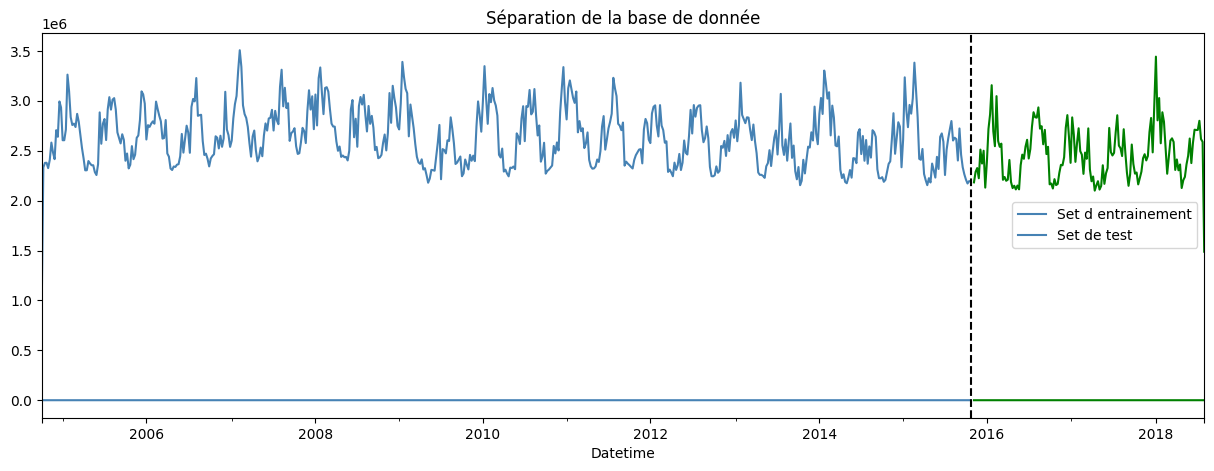

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
train_w.plot(ax=ax, label='Training Set', title='Séparation de la base de donnée',color='steelblue')
test_w.plot(ax=ax, label='Test Set',color='green')
ax.axvline('25-10-2015', color='black', ls='--')
ax.legend(['Set d entrainement','Set de test'])
plt.show()

In [9]:
#moyenne de la consommation des années précédentes 
train_model_week = train_w.groupby(["week_of_year"]).mean()
train_model_week = train_model_week.rename(columns={"AEP_MW":"prediction_w"})

In [10]:
#renvoie les prédictions dans une colonne
def predict (df,model):
    return df.merge(model, on="week_of_year",how="left")
test_predictions_week = predict(test_w,train_model_week)

<AxesSubplot:xlabel='Semaine de l année', ylabel='Consommation en MW'>

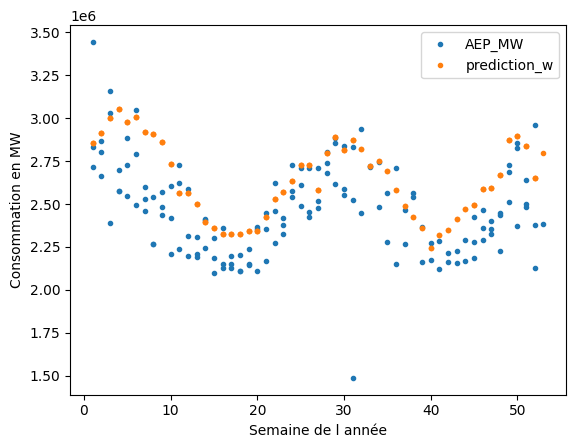

In [11]:
# pres
# affichage des prédictions
test_predictions_week.plot(x='week_of_year' ,y=['AEP_MW','prediction_w'], marker='.', linestyle='none',ylabel='Consommation en MW',xlabel='Semaine de l année')

In [12]:
test_predictions_week

,AEP_MW,week_of_year,prediction_w
0,2182841.0,45,2.491139e+06
1,2288004.0,46,2.589700e+06
2,2326099.0,47,2.591977e+06
3,2224256.0,48,2.666254e+06
4,2511069.0,49,2.869390e+06
...,...,...,...
139,2707980.0,27,2.583633e+06
140,2799780.0,28,2.794370e+06
141,2616533.0,29,2.887809e+06
142,2588782.0,30,2.811375e+06


<AxesSubplot:xlabel='Semaine de l année', ylabel='Consommation électrique en MW'>

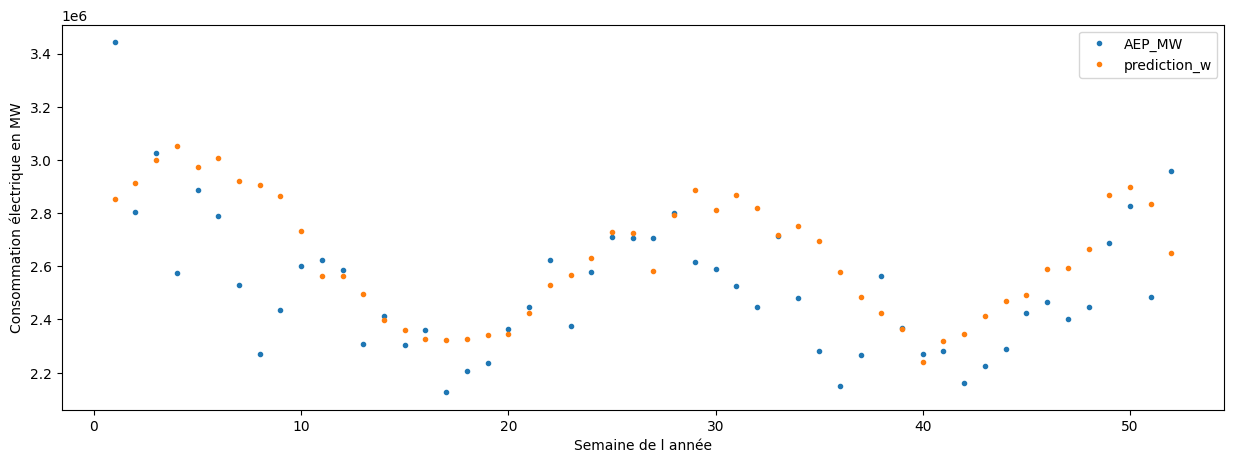

In [13]:
# pres
# plot de 50 semaines de consommation
test_predictions_week.loc[(test_predictions_week.index>90) & (test_predictions_week.index<143)].plot(x='week_of_year',xlabel='Semaine de l année',y=['AEP_MW','prediction_w'],ylabel='Consommation électrique en MW',figsize=(15,5),marker='.',linestyle='none')

##### Remarquons que notre modèla à tendance à sur estimier la consommation électrique. Nous l'expliquons par son apprentissage sur les 10 dernières années: en effet sur la courbe en dessous il est clair que la consommation electrique a diminué de façon affine. Ainsi notre modèle a appris sur des années avec une plus grande consommation. C'est donc cohérent que ses prédictions soit plus haute que les valeurs réelles.

/home/eloik/.local/lib/python3.8/site-packages/matplotlib/axis.py:1506: UserWarning: Parsing '25-10-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  ret = self.converter.convert(x, self.units, self)
/home/eloik/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:235: UserWarning: Parsing '25-10-2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  values = PeriodConverter._convert_1d(values, units, axis)


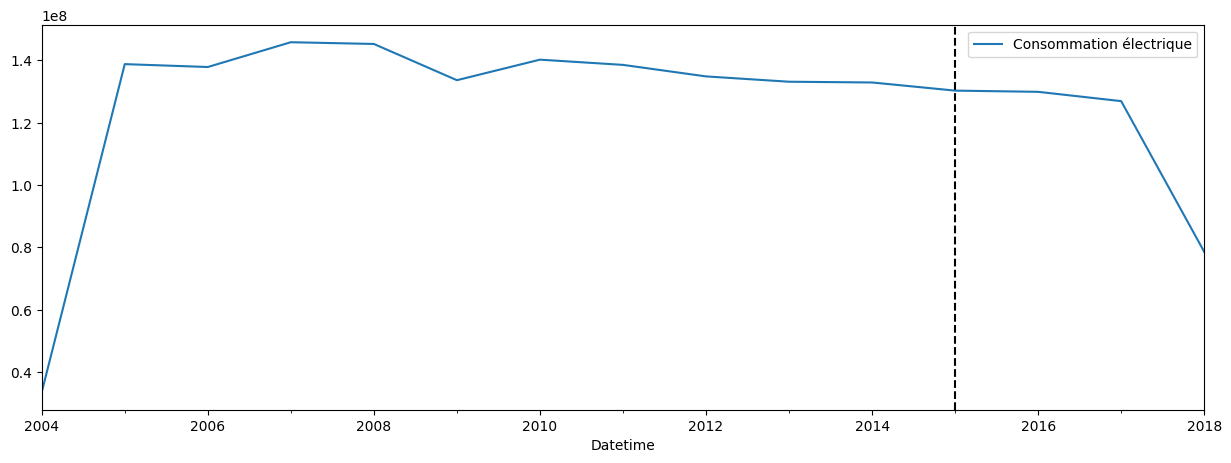

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
yearly_data.plot(ax=ax, label='Training Set' )
ax.axvline('25-10-2015', color='black', ls='--')
ax.legend(['Consommation électrique'])
plt.show()

In [24]:
#evaluation des prédictions
print("RMSE %s" %mean_squared_error(test_predictions_week["AEP_MW"],test_predictions_week["prediction_w"],squared= False))
print("MAE %s" %mean_absolute_error(test_predictions_week["AEP_MW"],test_predictions_week["prediction_w"]))
weekly_data.mean()

RMSE 279583.5628271335
MAE 214121.01388888888


AEP_MW          2.599824e+06
week_of_year    2.651037e+01
dtype: float64

##### Nous remarquons que sur une consommation moyenne par semaine de 2 599 824 MW notre modèle se trompe de 280 000 MW

## Nous travaillons sur la consommation par jour:

In [20]:
#numérote les jours de 1 à 7 et de 1 à 365
daily_data["day_of_week"] = daily_data.index.isocalendar().day
daily_data["day_of_year"] = daily_data.index.strftime("%j")

In [21]:
daily_data

,AEP_MW,day_of_week,day_of_year
Datetime,,,
2004-10-01,328544.0,5,275
2004-10-02,311997.0,6,276
2004-10-03,293450.0,7,277
2004-10-04,343417.0,1,278
2004-10-05,346553.0,2,279
...,...,...,...
2018-07-30,368834.0,1,211
2018-07-31,364327.0,2,212
2018-08-01,363628.0,3,213


In [22]:
#split train et test
nb_lines = daily_data.shape[0]
train = daily_data.iloc[:int(nb_lines*0.8)]
test = daily_data.iloc[int(nb_lines*0.8)+1:]

In [23]:
#moyenne de la consommation des années précédentes 
train_model = train.groupby(by=["day_of_year"]).mean()
train_model = train_model.rename(columns={"AEP_MW":"prediction"})


In [24]:
#renvoie les prédictions dans une colonne 
def predict(df,model):
    return df.merge(model, on ="day_of_year",how="left")
test_predictions_day = predict(test,train_model)

In [25]:
#affichage de la collonne des prédictions
test_predictions_day

,AEP_MW,day_of_week_x,day_of_year,prediction,day_of_week_y
0,319717.0,4,302,347580.090909,4.272727
1,329503.0,5,303,353971.818182,4.0
2,306814.0,6,304,352098.727273,3.727273
3,291351.0,7,305,348057.545455,4.090909
4,318224.0,1,306,356095.545455,3.818182
...,...,...,...,...,...
1005,368834.0,1,211,398409.000000,4.272727
1006,364327.0,2,212,404955.818182,4.0
1007,363628.0,3,213,413103.363636,3.727273
1008,376504.0,4,214,416967.818182,4.090909


<AxesSubplot:xlabel='Jour de l année', ylabel='Consommation électrique'>

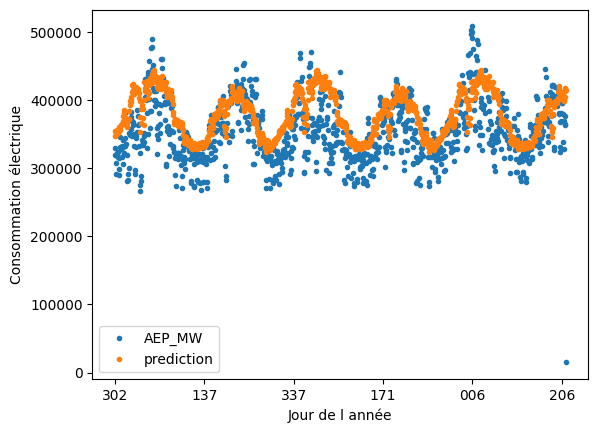

In [28]:
# plot des prédictions
test_predictions_day.plot(x='day_of_year', y=['AEP_MW','prediction'],marker='.',linestyle='none',ylabel='Consommation électrique',xlabel='Jour de l année')

<AxesSubplot:title={'center':'6 mois de prévisions'}, xlabel='jour de l année', ylabel='Consommation électrique'>

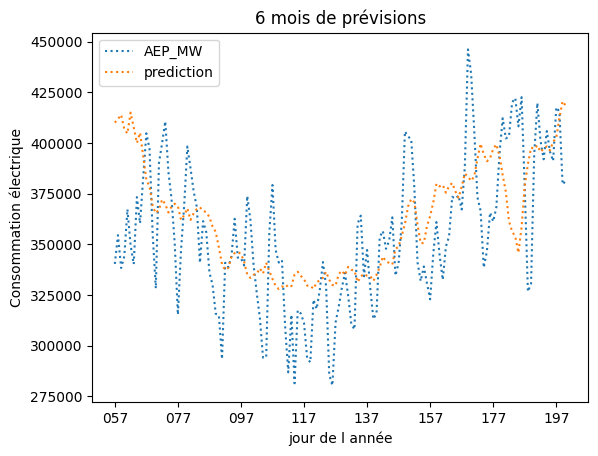

In [29]:
# plot de 6 mois
test_predictions_day.loc[(test_predictions_day.index> 850) & (test_predictions_day.index<995)] .plot(x='day_of_year', y=['AEP_MW','prediction'],linestyle='dotted',ylabel='Consommation électrique',xlabel='jour de l année',title='6 mois de prévisions')

##### De le même façon que précédemment, nous remarquons que notre modèle surestime la consommation électrique

In [23]:
#evaluation des prédictions
print("RMSE %s" %mean_squared_error(test_predictions_day["AEP_MW"],test_predictions_day["prediction"],squared= False))
print("MSE %s" %mean_absolute_error(test_predictions_day["AEP_MW"],test_predictions_day["prediction"]) )

RMSE 45819.38893986183
MSE 36082.749579958


In [24]:
daily_data.describe()

,AEP_MW,day_of_week
count,5055.000000,5055.000000
mean,371844.218991,4.000198
std,47605.308633,2.000049
min,14809.000000,1.000000
25%,337265.500000,2.000000
50%,366539.000000,4.000000
75%,403198.500000,6.000000
max,548349.000000,7.000000


##### Ainsi notre modèle se trompe en moyenne de 45 819 MW par jour, par rapport à une consommation electrique moyenne par jour de 371 844 MW . (Soit une erreur de 14%)